In [1]:
#Script to evaluate the determinants of patent citation 
#Renato Kogeyama

# Jan 21, 2020
# The current data does not have Class
# I should go back and get this info - but there are too many scripts now and
#   I should reorganize them before moving forward
# I should also include the patent publication date - to control for the policy changes
# In the citation file, I should change application number for grant when possible 
#   This will improve realiability of all measures related to citation
# Introduce classifications

# Jan 18, 2020
# Variables calculated
# Generality, average delay, forward and backward citations, cumulative citation (cit_tree)
# Still missing originality
# the file with variables that are used in this script should get a name independent from the date


#Miami, December 24th, 2019
# Prof. Rafael Corredoira suggested:
# - Inclusion of a tree of citations
#   To track back the source of citations. This is information is not given by direct count of citations.
# - Consider policy changes in the way patents are cited
#   Policy changes in 2000 changed the time frame of citation, and 2010 partially moved citation to applications
# - Track classification changes 
#   The original classification system in USPTO changed from a technical based to a market based classification system
#   See if there is an impact
# - Consider a text analysis of the claims
#   Classification is based on the claims but it is not clear how many claims are related to each classification category
# - Include moderation effect from classification
#   Citations patterns may change across industries, so some effects may disappear if industry is not accounted for.

# In summary, his ideas help increase structure of the current work


#Syracuse, December 3rd, 2019

#The original script is getting too complex
#There was many tentative scripts to play with data
#Here I am writing a script to show the relevance of variables to patent citation

#11-12-2019
#Introducing normalization

#10-11-2019
#I introduced log backward citation, what corrects for very dispersed results
#but the major problem is that few patents receive citations
#bring back binary output

#10-10-2019
#Added graphics and new distributions

#10-03-2019
#I rewrote the citation data to clean the strings

#09-15-2019
#O naive bayes tem algum problema com distribuicoes desbalanceadas
#o scikit learn tem um modulo que corrige count distributions com muitos zeros, o complementNB
#porem este nao esta disponivel na atual versao disponibilizada no HPC da FIU

#09-10-2019
#o trabalho pede uma abordagem mais sistematica e cuidadosa
#estou agrupando o codigo antigo comentado e vou comecar um novo codigo

#09-27-2019
#I am renaming citation as forward citation and backward citation

#09-17-2018

#Alto uso de memoria - rodar no Amazon AWS 



In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import naive_bayes
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

from scipy import stats
import datetime
import matplotlib.pyplot as plot
import pylab as pl

from math import sqrt


import sys
sys.path.append('/home/rkogeyam/scripts/')

from best_num_attr import best_num_attr
from xattrSelect import xattrSelect
from sampler import sampler
from normalize import normalize
from nbayes import nbayes





In [2]:
%matplotlib inline

In [3]:
fname='/home/rkogeyam/PATENT_CITATION/data/dataset.csv'

# df=pd.read_csv(fname)

sample_size=1000
df=sampler(fname, sample_size)

In [4]:
df.describe()

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,back_citation,parent_back_citation,forw_citation,mean_forw_delay,mean_back_delay
count,860.000000,860.000000,860.000000,568.000000,698.000000
mean,11.037209,160.247674,13.503488,13.644840,21.991238
std,26.309539,592.023035,66.785436,9.642182,26.211026
min,0.000000,0.000000,0.000000,0.758904,0.380822
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,343.000000,7755.000000,1558.000000,71.791781,135.980822


In [6]:
df.sample(n=10)

,Unnamed: 0,back_citation,parent_back_citation,forw_citation,mean_forw_delay,mean_back_delay
331,3677222,3.0,41.0,0.0,NaN,11.630137
54,0,0.0,0.0,1.0,NaN,NaN
320,3543391,2.0,30.0,0.0,NaN,16.147945
35,0,0.0,0.0,2.0,NaN,NaN
19,0,0.0,0.0,1.0,NaN,NaN
758,8114922,NaN,NaN,NaN,15.672945,NaN
790,8413031,NaN,NaN,NaN,5.884126,NaN
244,2609030,4.0,39.0,0.0,NaN,51.174658
243,2554113,3.0,34.0,0.0,NaN,44.652968
985,D721845,2.0,2.0,19.0,3.904110,1.864384


In [7]:
# df.rename(columns={'Unnamed: 0': 'patent_id'}, inplace=True)

In [8]:
df.set_index('patent_id', inplace=True)

In [8]:
# df.drop(['number', 'filename', 'abstract', 'title', 'patent_id', 'country', 'month', 'day'], axis=1, inplace=True)

#number is the same as id
#filename is not relevant
#abstract and title may be used in other opportunity, for now I drop them to save memory
#patent_id is not relevant here (it was the key for matching in a previous step)
#country is always US
#at this point, I am dropping month and day because they are not reliable source of information (see previous step)

In [9]:
df.sample(n=5)

,type,date,kind,num_claims,year,back_citation,parent_back_citation,forw_citation
id,,,,,,,,
7462736,utility,2008-12-09,B2,21.0,2008.0,0.0,0.0,0.0
7239695,utility,2007-07-03,B2,28.0,2007.0,0.0,0.0,0.0
6727743,utility,2004-04-27,B2,34.0,2004.0,2.0,1.0,6.0
8212193,utility,2012-07-03,B2,14.0,2012.0,0.0,0.0,0.0
3980802,utility,1976-09-14,A,9.0,1976.0,0.0,0.0,0.0


In [10]:
df.drop('date', axis=1, inplace=True)

In [11]:
df.shape

(6488254, 7)

In [12]:
df=df.dropna()

In [13]:
df.shape

(6488250, 7)

In [14]:
df.groupby('type').count().iloc[:,2]

type
TVPP                                      3
defensive publication                   509
design                               563003
plant                                 24790
reissue                               17812
statutory invention registration       2254
utility                             5879879
Name: year, dtype: int64

In [15]:
# defensive publication and statutory registration are not wrong entries
# I will just rename them and leave them in the dataset
df.groupby('kind').count().iloc[:,2]

kind
A     2391379
B1     568083
B2    2920417
E        8692
E1       9120
H        1982
H1        272
I4        509
I5          3
P        8282
P2      11401
P3       5107
S      209582
S1     353421
Name: year, dtype: int64

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_claims,6488250.0,14.143219,12.004228,0.0,6.0,12.0,20.0,887.0
year,6488250.0,2002.723440,11.322681,1976.0,1995.0,2005.0,2013.0,2017.0
back_citation,6488250.0,7.257143,25.692059,0.0,0.0,0.0,5.0,3433.0
parent_back_citation,6488250.0,100.546808,1066.788244,0.0,0.0,0.0,13.0,156715.0
forw_citation,6488250.0,7.831692,29.595450,0.0,0.0,0.0,7.0,5811.0


In [17]:
df.dtypes

type                     object
kind                     object
num_claims              float64
year                    float64
back_citation           float64
parent_back_citation    float64
forw_citation           float64
dtype: object

In [18]:
# normalization
# df=normalize(df)

In [19]:
#maybe nb fit does not accept nomalized data, so i using data without normalize
#but in that case, i have to transform the categorical variables

obj_cols=list(df.select_dtypes(include=[object]).columns.values)

for col in obj_cols:
    df[col] = df[col].astype('category')

df=pd.get_dummies(df, columns=obj_cols, prefix=obj_cols)

In [20]:
# defensive publication and statutory registration are not wrong entries
# I will just rename them and leave them in the dataset
# df.rename(columns={'defensive publication': 'defensive', 'statutory invention registration': 'statutory'}, inplace=True)
df=df.rename(columns={'type_defensive publication': 'type_defensive', 'type_statutory invention registration': 'type_statutory'})

In [21]:
# List of IVs
chosenColumns=df.columns.values.tolist()
len(chosenColumns)

26

In [22]:
chosenColumns

['num_claims',
 'year',
 'back_citation',
 'parent_back_citation',
 'forw_citation',
 'type_TVPP',
 'type_defensive',
 'type_design',
 'type_plant',
 'type_reissue',
 'type_statutory',
 'type_utility',
 'kind_A',
 'kind_B1',
 'kind_B2',
 'kind_E',
 'kind_E1',
 'kind_H',
 'kind_H1',
 'kind_I4',
 'kind_I5',
 'kind_P',
 'kind_P2',
 'kind_P3',
 'kind_S',
 'kind_S1']

In [23]:
# chosenColumns.remove(['back_citation'])
len(chosenColumns)

# chosenColumns.remove(['parent_back_citation'])
# len(chosenColumns)

# chosenColumns.remove('citation_bi')
# chosenColumns.remove('log_back_cit')

myX = df.as_matrix(columns=chosenColumns)
myY = df.as_matrix(columns=['back_citation'])

xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 
# testSize = yTest.shape[0]
# trainSize = yTrain.shape[0]

/home/applications/anaconda3/4.2.0/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
# best_num_attr(myX, xTrain, xTest, yTrain, yTest, chosenColumns, regtype='linear')

In [25]:
df.var().sort_values()

kind_I5                 4.623741e-07
type_TVPP               4.623741e-07
kind_H1                 4.192018e-05
type_defensive          7.844336e-05
kind_I4                 7.844336e-05
kind_H                  3.053820e-04
type_statutory          3.472766e-04
kind_P3                 7.864957e-04
kind_P                  1.274832e-03
kind_E                  1.337858e-03
kind_E1                 1.403642e-03
kind_P2                 1.754089e-03
type_reissue            2.737734e-03
type_plant              3.806155e-03
kind_S                  3.125838e-02
kind_S1                 5.150385e-02
type_design             7.924321e-02
kind_B1                 7.988968e-02
type_utility            8.497317e-02
kind_A                  2.327264e-01
kind_B2                 2.475109e-01
year                    1.282031e+02
num_claims              1.441015e+02
back_citation           6.600819e+02
forw_citation           8.758906e+02
parent_back_citation    1.138037e+06
dtype: float64

In [26]:
df.shape

(6488250, 26)

In [27]:
df.shape

(6488250, 26)

In [28]:
# This selector does not work because almost every attribute is p-value significant

# selector = SelectKBest(f_classif, k=4) #initialize 
# selector.fit(myX, myY) #fit
# scores = -np.log10(selector.pvalues_) #transform pvalues (why?)
# scores /= scores.max() #normalize 
# plt.bar(myX - .45, scores, width=.2,
#         label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
#         edgecolor='black')

In [29]:
# nbayes(xTrain, yTrain, xTest, yTest)

In [30]:
# #Let's do something else
# #Change the DV 

# myX = df.as_matrix(columns=chosenColumns)
# myY = df.as_matrix(columns=['parent_back_citation'])

# xTrain, xTest, yTrain, yTest = train_test_split(myX, myY, train_size=0.7, random_state=3) 

In [31]:
# nbayes(xTrain, yTrain, xTest, yTest)

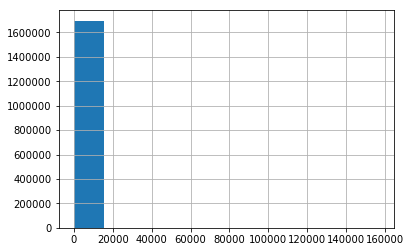

In [32]:
df.parent_back_citation.boxplot()

In [33]:
#and graphs of back citation in time